# CNN Model for region-of-interest (ROI)


## Preprocessing


### Imports


In [22]:
import pandas as pd
from pathlib import Path
import shutil
import cv2 as cv
import numpy as np


In [23]:
meta_dir = "../data/metadata"
image_dir = "../data/images"
train_path = "./roi_images/train"
val_path = "./roi_images/val"
test_path = "./roi_images/test"


In [24]:
Path(train_path + "/benign").mkdir(parents=True, exist_ok=True)
Path(train_path + "/malignant").mkdir(parents=True, exist_ok=True)
Path(val_path + "/benign").mkdir(parents=True, exist_ok=True)
Path(val_path + "/malignant").mkdir(parents=True, exist_ok=True)
Path(test_path + "/benign").mkdir(parents=True, exist_ok=True)
Path(test_path + "/malignant").mkdir(parents=True, exist_ok=True)


In [25]:
dicom_data = pd.read_csv(meta_dir + "/dicom_info.csv")
train_csv = pd.read_csv(meta_dir + "/mass_case_description_train_set.csv")
test_csv = pd.read_csv(meta_dir + "/mass_case_description_test_set.csv")
train_csv = train_csv[["patient_id", "pathology", "ROI mask file path"]]
test_csv = test_csv[["patient_id", "pathology", "ROI mask file path"]]


In [26]:
dicom_data = dicom_data[["PatientID", "SeriesDescription", "image_path"]]


In [27]:
images = dicom_data[dicom_data.SeriesDescription == "ROI mask images"]
train_images = images[
    images.PatientID.isin(
        train_csv["ROI mask file path"].apply(lambda x: x.split("/")[0])
    )
]
test_images = images[
    images.PatientID.isin(
        test_csv["ROI mask file path"].apply(lambda x: x.split("/")[0])
    )
]


In [28]:
train_images = train_images.sort_values(by=["PatientID"]).reset_index(drop=True)
# Concatenate train_images and train_csv
train_images = pd.concat([train_images, train_csv], axis=1)
train_images.drop(
    ["patient_id", "SeriesDescription", "ROI mask file path"], axis=1, inplace=True
)

test_images = test_images.sort_values(by=["PatientID"]).reset_index(drop=True)
# Concatenate test_images and test_csv
test_images = pd.concat([test_images, test_csv], axis=1)
test_images.drop(
    ["patient_id", "SeriesDescription", "ROI mask file path"], axis=1, inplace=True
)


In [29]:
split = int(len(train_images) * 0.8)
train_images = train_images.iloc[ : split]
val_images = train_images.iloc[split : ]


In [30]:
def fix_path(images):
    paths = images.image_path.apply(lambda x: x.replace("CBIS-DDSM/jpeg", ""))
    return paths


In [31]:
train_images_paths = fix_path(train_images)
val_images_paths = fix_path(val_images)
test_images_paths = fix_path(test_images)
train_labels = train_images.pathology.apply(lambda x: x.lower())
val_labels = val_images.pathology.apply(lambda x: x.lower())
test_labels = test_images.pathology.apply(lambda x: x.lower())


In [32]:
def copy_images(curr_paths, dest_paths, curr_labels):
    start = 0 if dest_paths != val_path else len(curr_labels) - 1
    new_paths = []
    for i, path in enumerate(curr_paths, start):
        dir_path = path.split("/")[1]
        label = curr_labels[i]
        if label == "benign_without_callback":
            label = "benign"
        new_path = dest_paths + "/" + label
        Path(new_path + "/" + dir_path).mkdir(parents=True, exist_ok=True)
        shutil.copy(image_dir + path, new_path + path)
        new_paths.append(new_path + path)
    return new_paths


In [33]:
new_train_paths = copy_images(train_images_paths, train_path, train_labels)
new_val_paths = copy_images(val_images_paths, val_path, val_labels)
new_test_paths = copy_images(test_images_paths, test_path, test_labels)


In [34]:
def crop_image(img):
    mask = img > 0
    m, n = img.shape
    mask0, mask1 = mask.any(0), mask.any(1)
    col_start, col_end = mask0.argmax(), n - mask0[::-1].argmax()
    row_start, row_end = mask1.argmax(), m - mask1[::-1].argmax()
    return img[row_start:row_end, col_start:col_end]


def crop_images(paths):
    for path in paths:
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        cropped = crop_image(img)
        cv.imwrite(path, cropped)


In [35]:
crop_images(new_train_paths)
crop_images(new_val_paths)
crop_images(new_test_paths)


# Model

## Image loading

### Imports


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


### Parameters


In [2]:
batch_size = 4
train_path = "./roi_images/train"
val_path = "./roi_images/test"
test_path = "./roi_images/test"


### Load and transform the images


In [3]:
transformer = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [4]:
train_imagefolder = torchvision.datasets.ImageFolder(
    root=train_path, transform=transformer
)
train_loader = torch.utils.data.DataLoader(
    train_imagefolder, batch_size=batch_size, shuffle=True, num_workers=0
)


In [5]:
val_imagefolder = torchvision.datasets.ImageFolder(root=val_path, transform=transformer)
val_loader = torch.utils.data.DataLoader(
    val_imagefolder, batch_size=batch_size, shuffle=True, num_workers=0
)


In [6]:
test_imagefolder = torchvision.datasets.ImageFolder(
    root=test_path, transform=transformer
)
test_loader = torch.utils.data.DataLoader(
    test_imagefolder, batch_size=1, shuffle=True, num_workers=0
)


In [7]:
train_imagefolder.class_to_idx


{'benign': 0, 'malignant': 1}

## Neural network


### Imports


In [8]:
from network import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

In [9]:
model = Model(0.01, 0.9, train_loader, val_loader, test_loader)

### Training the model

In [10]:
train = True # Set to True to train the model
epochs = 25

In [11]:
if train:
    accuracy, losses, val_accuracies, val_losses = model.train(epochs)
    model.save()


Validation accuracy: 48.1481
0.7218949769672595 inf
Epoch [1/25], Loss: 0.7159
Validation accuracy: 50.7937
0.7051375900444231 0.7218949769672595
Epoch [2/25], Loss: 0.6919


KeyboardInterrupt: 

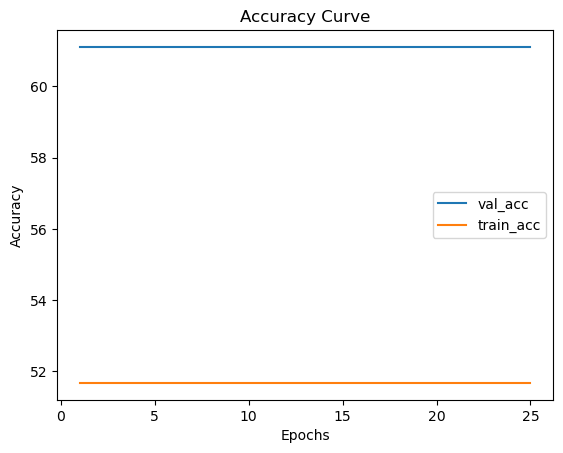

In [ ]:
if train:    
    plt.title("Accuracy Curve")
    sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label="val_acc")
    sns.lineplot(x=range(1, len(accuracy) + 1), y=accuracy, label="train_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

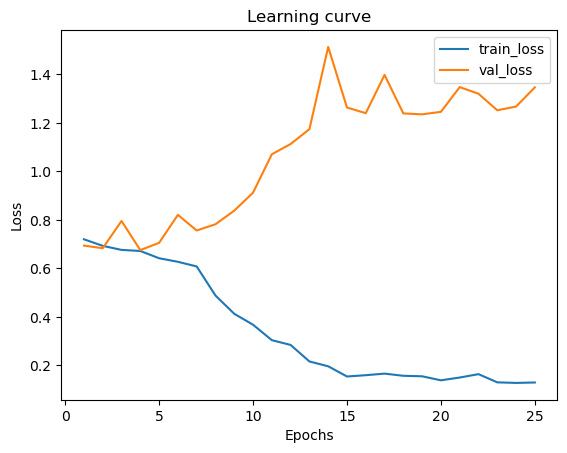

In [ ]:
if train:
    plt.title("Learning curve")
    sns.lineplot(x=range(1, len(losses) + 1), y=losses, label="train_loss")
    sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

## Evaluate

In [ ]:
model.load()

In [ ]:
y_label, y_pred = model.evaluate()

In [ ]:
tp = np.sum(y_label * y_pred)
tn = np.sum((1 - y_label) * (1 - y_pred))
fp = np.sum((1 - y_label) * y_pred)
fn = np.sum(y_label * (1 - y_pred))


In [ ]:
final_accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {final_accuracy:.2f}")

Accuracy: 0.61


In [ ]:
recall_m = tp / (tp + fn)
recall_b = tn / (tn + fp)
precision_m = tp / (tp + fp)
precision_b = tn / (tn + fn)

C:\Users\noonoo\AppData\Local\Temp\ipykernel_3288\2787840472.py:3: RuntimeWarning: invalid value encountered in long_scalars
  precision_m = tp / (tp + fp)


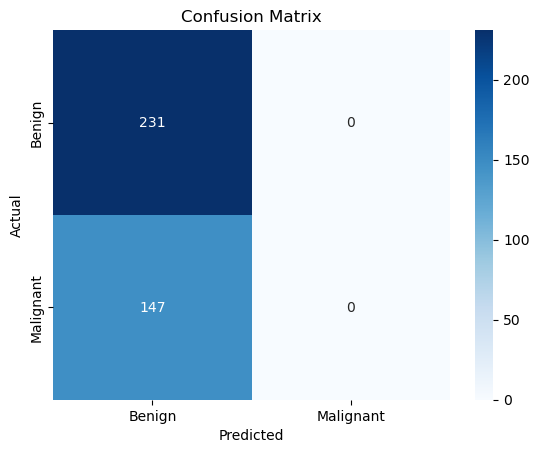

In [ ]:
sns.heatmap(
    np.array([[tn, fp], [fn, tp]]),
    annot=True,
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
    fmt="d",
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
print(f"Precision for malignant: {precision_m:.2f}")
print(f"Recall for malignant: {recall_m:.2f}")
print(f"Precision for benign: {precision_b:.2f}")
print(f"Recall for benign: {recall_b:.2f}")


Precision for malignant: nan
Recall for malignant: 0.00
Precision for benign: 0.61
Recall for benign: 1.00


In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_label), np.array(y_pred))
roc_auc = auc(fpr, tpr)


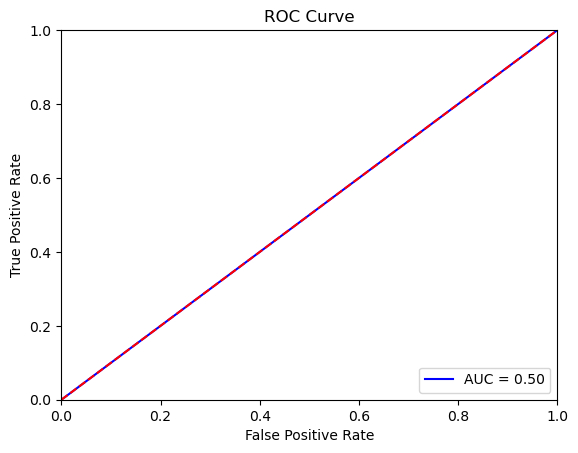

In [ ]:
# Plot roc curve and auc
plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.legend(loc="lower right")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [ ]:
f1score_m = 2 * (precision_m * recall_m) / (precision_m + recall_m)
f1score_b = 2 * (precision_b * recall_b) / (precision_b + recall_b)
print(f"F1 Score malignant: {f1score_m:.2f}")
print(f"F1 Score benign: {f1score_b:.2f}")


F1 Score malignant: nan
F1 Score benign: 0.76
